In [1]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta

import sorts
import pyant
import pyorb

print(f'sorts=={sorts.__version__}')
print(f'pyorb=={pyorb.__version__}')
print(f'pyant=={pyant.__version__}')
plt.style.use('dark_background')

base = Path('/home/danielk/git/antisat_analysis/projects/output/russian_asat')
data_path = Path('/home/danielk/data/spade/beamparks/uhf/2021.11.23/leo_bpark_2.1u_NO@uhf_extended')

sorts==4.0.0
pyorb==0.4.4
pyant==0.8.5


In [2]:
correlation_select_file = base / '2021.11.23_uhf_correlation_plots/eiscat_uhf_selected_correlations.npy'
correlation_file = base/ '2021.11.23_uhf_correlation.pickle'

correlation_select = np.load(correlation_select_file)

with h5py.File(correlation_file, 'r') as ds:
    indecies = ds['matched_object_index'][()]
    name = ds.attrs['radar_name']

measurnment_id = np.arange(indecies.shape[1])

In [3]:
tle_file = base / '2021_11_23_spacetrack.tle'
pop = sorts.population.tle_catalog(tle_file, cartesian=False)
pop.unique()

In [4]:
events_file = data_path / '20211123_12/events.txt'
extended_files = []
with open(events_file, 'r') as fh:
    for ind, line in enumerate(fh):
        if ind < 33 or len(line.strip()) == 0:
            continue
        #filter the SNR like with the h5 files
        if float(line[69:76])**2.0 <= 33:
            print(f'skipping {line[69:76]} ratio target')
            continue
        extended_files.append(line[181:].strip())

skipping    5.3  ratio target
skipping    5.5  ratio target
skipping    5.1  ratio target
skipping    5.2  ratio target


In [5]:
spade_file = base / 'uhf/2021.11.23.h5'
with h5py.File(spade_file, 'r') as h_det:
    r = h_det['r'][()]*1e3  # km -> m, one way
    t = h_det['t'][()]  # Unix seconds
    v = h_det['v'][()]*1e3  # km/s -> m/s
    inds = np.argsort(t)
    t = t[inds]
    r = r[inds]
    v = v[inds]

    times = Time(t, format='unix', scale='utc')
    epoch = times[0]
    t = (times - epoch).sec

In [6]:
#select only from sub_folder
t0 = Time('2021-11-23 12:00:00', format='iso', scale='utc')
t1 = Time('2021-11-23 13:00:00', format='iso', scale='utc')

sub_select_inds = np.logical_and(
    times >= t0, 
    times <= t1,
)
sub_measurnment_id = measurnment_id[sub_select_inds]
sub_correlation_select = correlation_select[sub_select_inds]
sub_indecies = indecies.flatten()[sub_select_inds]

correlated_measurnment_id = sub_measurnment_id[sub_correlation_select]
correlated_object_id = sub_indecies[sub_correlation_select]

extended_files = np.array(extended_files)
correlated_extended_files = extended_files[sub_correlation_select]

In [7]:
#These are all indexed according to measurnment id
print(len(sub_select_inds))
print(len(measurnment_id))
print(len(correlation_select))
print(len(indecies.flatten()))
#these are for extended data
print(len(sub_measurnment_id))
print(len(sub_correlation_select))
print(len(sub_indecies))
print(len(extended_files))
#these are the correlated measurnments and their objects
print(len(correlated_measurnment_id))
print(len(correlated_object_id))
print(len(correlated_extended_files))

572
572
572
572
184
184
184
184
37
37
37


In [8]:
#select one
select_id = 1

meas_id = correlated_measurnment_id[select_id]
obj_id = correlated_object_id[select_id]
ext_data_file = str(correlated_extended_files[select_id])
print(meas_id)
print(obj_id)
print(ext_data_file)

149
1464
uhf_20211123_120429_800000


In [9]:
obj = pop.get_object(obj_id)
print(obj)
obj.out_frame = 'ITRS'


Space object 7018: <Time object: scale='utc' format='mjd' value=59540.47154035978>:
(b'1 07018U 73086J   21326.47154036 -.00000032  00000-0  11004-3 0  9999', b'2 07018 102.2616 305.1845 0012150 258.3358 255.1014 12.39017587171870')
Parameters: C_D=2.3, m=0.07696431180023906, C_R=1.0, d=0.3086315035391251


### From https://www.n2yo.com/satellite/?s=13801

#### obj0

* NORAD ID: 13801 
* Int'l Code: 1981-053GY 
* Perigee: 841.1 km 
* Apogee: 906.4 km 
* Inclination: 82.8 ° 
* Period: 102.3 minutes 
* Semi major axis: 7244 km 
* RCS: 0.0143 m2 (small) 
* Launch date: June 4, 1981
* Source: Commonwealth of Independent States (former USSR) (CIS)
* Launch site: PLESETSK MISSILE AND SPACE COMPLEX (PKMTR)

#### obj1

* NORAD ID: 7018 
* Int'l Code: 1973-086J 
* Perigee: 1,508.3 km 
* Apogee: 1,527.5 km 
* Inclination: 102.3 ° 
* Period: 116.2 minutes 
* Semi major axis: 7888 km 
* RCS: 1.0398 m2 (large) 
* Launch date: November 6, 1973
* Source: United States (US)
* Launch site: AIR FORCE WESTERN TEST RANGE (AFWTR)


In [10]:
from determine_beampark_rcs import load_spade_extended

data_file = data_path / f'20211123_12/{ext_data_file}/{ext_data_file}.hlist'
data = load_spade_extended(data_file)

In [11]:
est_diam = 1e0

In [12]:
radar = sorts.radars.eiscat_uhf
radar.tx[0].beam.sph_point(azimuth=90, elevation=75)

In [13]:
dt = (times[meas_id] - obj.epoch).sec
peak_snr_id = np.argmax(data['SNR'].values)
t_vec = data['t'].values - data['t'].values[peak_snr_id]

states_ecef = obj.get_state(dt + t_vec)
ecef_r = states_ecef[:3, :] - radar.tx[0].ecef[:, None]

local_pos = sorts.frames.ecef_to_enu(
    radar.tx[0].lat, 
    radar.tx[0].lon, 
    radar.tx[0].alt, 
    ecef_r,
    radians=False,
)

pth = local_pos/np.linalg.norm(local_pos, axis=0)
G_pth = radar.tx[0].beam.gain(pth)
G_pth_db = 10*np.log10(G_pth)
diam = sorts.signals.hard_target_diameter(
    G_pth, 
    G_pth,
    radar.tx[0].wavelength,
    radar.tx[0].power,
    data['r'].values, 
    data['r'].values,
    data['SNR'].values, 
    bandwidth=radar.tx[0].coh_int_bandwidth,
    rx_noise_temp=radar.rx[0].noise,
    radar_albedo=1.0,
)
SNR_sim = sorts.signals.hard_target_snr(
    G_pth, 
    G_pth,
    radar.tx[0].wavelength,
    radar.tx[0].power,
    data['r'].values, 
    data['r'].values,
    diameter=est_diam, 
    bandwidth=radar.tx[0].coh_int_bandwidth,
    rx_noise_temp=radar.rx[0].noise,
    radar_albedo=1.0,
)

In [14]:
G_db_lim = 28
diam[G_pth_db < G_db_lim] = np.nan
SNR_sim[G_pth_db < G_db_lim] = 0

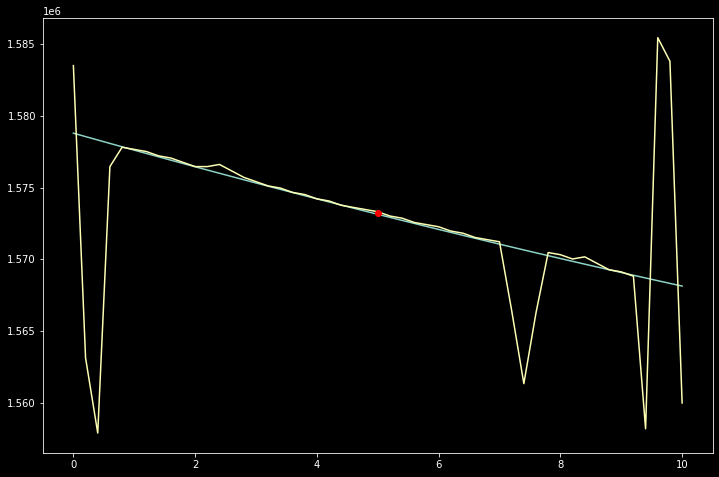

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data['t'], np.linalg.norm(ecef_r, axis=0))
ax.plot(data['t'], data['r'])
ax.plot([data['t'].values[peak_snr_id]], [r[meas_id]], 'or')

fig.savefig(OUTPUT / 'correlated_pass_range_match.png')

/home/danielk/tmp/ipykernel_2538465/1235069096.py:19: RuntimeWarning: divide by zero encountered in log10
  axes[1, 1].plot(data['t'], 10*np.log10(SNR_sim/np.max(SNR_sim)), label='Estimated')


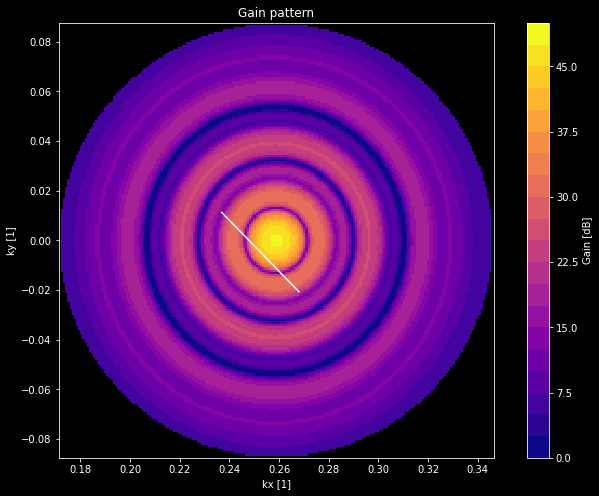

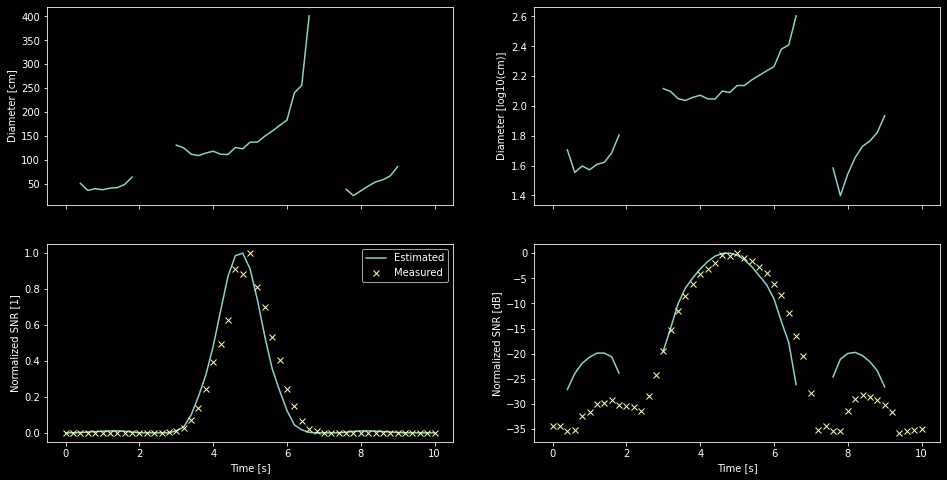

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pth[0, :], pth[1, :], '-w')
pyant.plotting.gain_heatmap(radar.tx[0].beam, min_elevation=85.0, ax=ax)

HERE = Path('.').resolve()
OUTPUT = HERE / 'output' / 'RCS_test_plots' 
OUTPUT.mkdir(exist_ok=True)
fig.savefig(OUTPUT / 'correlated_pass_pth_gain.png')

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)
axes[0, 0].plot(data['t'], diam*1e2)
axes[0, 0].set_ylabel('Diameter [cm]')
axes[0, 1].plot(data['t'], np.log10(diam*1e2))
axes[0, 1].set_ylabel('Diameter [log10(cm)]')
axes[1, 0].set_xlabel('Time [s]')

axes[1, 0].plot(data['t'], SNR_sim/np.max(SNR_sim), label='Estimated')
axes[1, 0].plot(data['t'], data['SNR'].values/np.max(data['SNR'].values), 'x', label='Measured')
axes[1, 1].plot(data['t'], 10*np.log10(SNR_sim/np.max(SNR_sim)), label='Estimated')
axes[1, 1].plot(data['t'], 10*np.log10(data['SNR'].values/np.max(data['SNR'].values)), 'x', label='Measured')
axes[1, 0].legend()
axes[1, 1].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Normalized SNR [1]')
axes[1, 1].set_ylabel('Normalized SNR [dB]')
fig.savefig(OUTPUT / 'correlated_pass_snr_match.png')


In [20]:
offset_angle = pyant.coordinates.vector_angle(
     pth[:, peak_snr_id], 
     radar.tx[0].beam.pointing, 
     radians=False,
)
print(f'offaxis angle {offset_angle} deg')

offaxis angle 0.46189132925925813 deg
